Importo i dati modello dell'iris e divido i dati in 5 array che contengono: 
sl: sepal length 
sw: sepal width
pl: petal length
pw: petal width
tn: target name (0:setosa ,1:versicolor , 2: virginica)

Matrice di dispersione dei tre tipi di iris

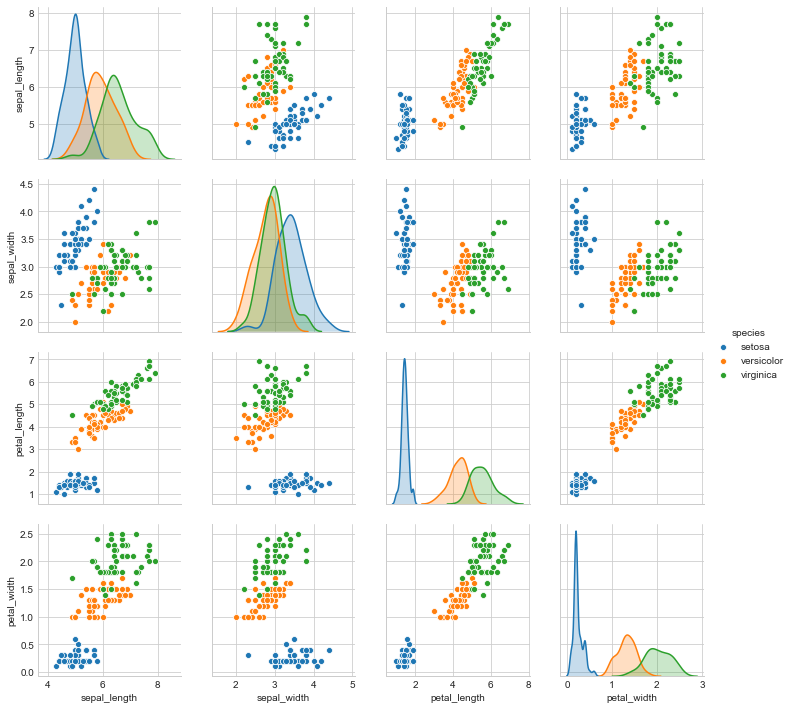

In [40]:
import seaborn as sns
df = sns.load_dataset("iris")
sns.pairplot(df, hue="species")

Dai grafici di dispersione vedo che il più consistente è petal_width petal_length, mi concentro a trovare un vettore che mi clusterizza i tre diversi gruppi

<function matplotlib.pyplot.show>

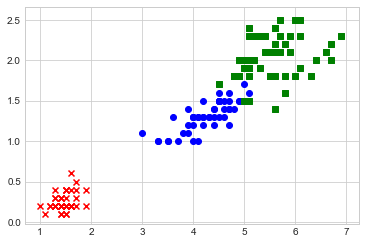

In [41]:
import matplotlib.pyplot as pyplot
pyplot.style.use('seaborn-whitegrid')

fig, ax = pyplot.subplots()
#plot x=sl , y=sw
for i in range(len(df)):
    if df.species[i]=='setosa':
        ax.scatter(df.petal_length[i], df.petal_width[i], c='red',marker='x')
    elif  df.species[i]=='versicolor':
        ax.scatter(df.petal_length[i], df.petal_width[i], c='blue',marker='o')
    elif df.species[i]=='virginica':
        ax.scatter(df.petal_length[i], df.petal_width[i], c='green',marker='s')
pyplot.show

Rimpiazzo i nomi delle iris con i valori 0,1,2

In [42]:
df=df.replace(to_replace='setosa',value=0)
df=df.replace(to_replace='versicolor',value=1)
df=df.replace(to_replace='virginica',value=2)
setosa= df.loc[df['species']==0]
setosa.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [283]:
xs=df.query('species == 0')
xs=xs.filter(items=['sepal_length', 'sepal_width','petal_length','petal_width']).values
n=len(xs)
print('creato array "xs" contenente solo una specie e "n" la sua grandezza')

creato array "xs" contenente solo una specie e "n" la sua grandezza


In [46]:
#implementazione funzione kernel
import numpy as np
def gaussian_kernel(q):
    return lambda x1,x2: np.exp(np.multiply(-q,np.linalg.norm(np.subtract(x1,x2))**2))
k=gaussian_kernel(3)
print('Creata funzione kernel k(x1,x2)')

Creata funzione k(x1,x2)


In [200]:
km=np.zeros([n,n])
for i in range(n):
    for j in range(n):
        km[i][j]=k(xs[i],xs[j])
print('Creata kernel matrix km[i][j]')
km

Creata kernel matrix km[i][j]


array([[1.        , 0.41895155, 0.45840601, ..., 0.36059494, 0.76337949,
        0.86070798],
       [0.41895155, 1.        , 0.76337949, ..., 0.67705687, 0.13806924,
        0.74081822],
       [0.45840601, 0.76337949, 1.        , ..., 0.94176453, 0.14227407,
        0.71892373],
       ...,
       [0.36059494, 0.67705687, 0.94176453, ..., 1.        , 0.10539922,
        0.60049558],
       [0.76337949, 0.13806924, 0.14227407, ..., 0.10539922, 1.        ,
        0.45840601],
       [0.86070798, 0.74081822, 0.71892373, ..., 0.60049558, 0.45840601,
        1.        ]])

In [263]:
#ottimizzazione beta
C=1
lower_bound=0.
upper_bound=C

from gurobipy import *
m= Model('Ottimizzazione')
beta=m.addVars(50, lb=lower_bound, ub=upper_bound, vtype=GRB.CONTINUOUS, name='beta')
m.addConstr(beta.sum()==1)
expr=0
for i in range(n):
    expr+=beta[i]*km[i][i]
for i in range(n):
    for j in range(n):
        expr-=beta[i]*beta[j]*km[i][j]      
m.setObjective(expr, GRB.MAXIMIZE)
m.update()
m.optimize()

Optimize a model with 1 rows, 50 columns and 50 nonzeros
Model has 1275 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [8e-08, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 50 columns, 50 nonzeros
Presolved model has 1275 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 49
 AA' NZ     : 1.225e+03
 Factor NZ  : 1.275e+03
 Factor Ops : 4.292e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.57754992e+05  4.84755992e+05  9.37e+03 8.00e+00  2.54e+05     0s
   1  -1.73383230e+05  1.91717109e+05  1.32e+03 1.68e-04  3.91e+04     0s
   2  -5.13770259e+04  5.40806982e+04  1.68e+02 2.15e-05  5.89e+03     0s
   3  -4.62150373e+03  5.16188827e+03  1.61e+01 2.06e-06  6.55

In [273]:
bbk=np.zeros([n,n])
for i in range(n):
    for j in range(n):
        bbk=beta[i].x * beta[j].x * k(xs[i],xs[j])
        
r2 = lambda x : k(x,x) - 2*np.sum(np.fromiter((beta[j].x* k(xs[j],x) for j in range(n)), dtype=float)) + bbk

In [281]:
p=np.zeros(n)
for i in range(n):
    p[i]=r2(xs[i])

array([0.44517004, 0.37555075, 0.425012  , 0.38536357, 0.44335383,
       0.41574822, 0.3971038 , 0.45760544, 0.35716857, 0.38899968,
       0.45187802, 0.43553609, 0.3768116 , 0.35716582, 0.35716582,
       0.35716582, 0.40356941, 0.44723242, 0.35716582, 0.43933045,
       0.35716582, 0.43838345, 0.35716582, 0.36891245, 0.35716582,
       0.35716582, 0.44328942, 0.45014632, 0.41820101, 0.39895492,
       0.39834725, 0.36415765, 0.35716582, 0.41686813, 0.40726849,
       0.35716582, 0.35716582, 0.41120182, 0.38024383, 0.4494732 ,
       0.42683574, 0.35716582, 0.37612025, 0.35716582, 0.35716582,
       0.38385972, 0.43532243, 0.41034461, 0.45908577, 0.43203997])

<function matplotlib.pyplot.show>

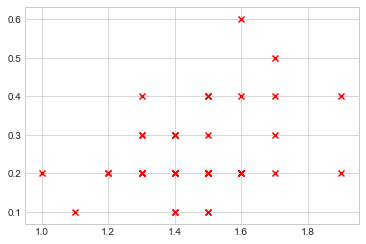

In [284]:
import matplotlib.pyplot as pyplot
pyplot.style.use('seaborn-whitegrid')

fig, ax = pyplot.subplots()
#plot x=sl , y=sw
for i in range(n):
    ax.scatter(xs[i][2],xs[i][3],c='red',marker='x')

pyplot.show

In [270]:
#divido il mio dataset in 80% per allenare il modello e 20% per allenare il modello
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="species"), df.species, test_size = 0.20)

from sklearn import svm
clf = svm.SVC(kernel='rbf', C=6, gamma=.10)
clf.fit(X_train,y_train)
clf.predict(X_test)
clf.score(X_test,y_test)

from sklearn import svm
clf = svm.SVC(kernel='rbf', C=1, gamma=24)
clf.fit(df.drop(columns="species"),df.species)
clf.predict(df.drop(columns="species"))
clf.score(df.drop(columns="species"),df.species)